Author: Laiya Lubben (llubben@umich.edu)
<br/>Last updated: Aug 19, 2021

# **1. Import libraries**



In [1]:
# Here is a list of libraries we need to conduct the analysis:
import pandas as pd                                           # Loading files into pandas dataframe
import numpy as np                                            # To use numpy aggregation functions
from tqdm.auto import tqdm                                    # track loop time
import warnings                                               # Suppress all warnings
warnings.filterwarnings('ignore')

import pymysql                                                # connect to database
import re
import json
import model_shared_utilities as msu                          # helper functions created to create model/plots
# --------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                               # Generate visualization 
import matplotlib.cm as cm
import altair as alt                                          
import seaborn as sns
# --------------------------------------------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer   # Transforming dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# --------------------------------------------------------------------------------------------------
from sklearn.cluster import KMeans, MiniBatchKMeans           # Model Training
from sklearn.metrics import silhouette_samples, silhouette_score
# --------------------------------------------------------------------------------------------------
import nltk                                                   # Downloading necessary packagings from nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer 
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laiya\AppData\Roaming\nltk_data...
[nltk

True

In [2]:
# use this to set random_state to reproduce the same result
RANDOM_SEED = 14


# **2. Helper Functions**

In the *model_shared_utilities* module,  we have created several helper functions (listed below) that generate plots to evaluate cluste quality and extract helpful information.

1. extract_relevantjobs(df, col=None): 
  * extract data science related jobs based on job titles
2. generate_SSE_plot(data, max_k, model, RANDOM_SEED): 
  * plot the sum of squared distance between centroid and each member of the cluster 
3. generate_avg_silhouette_plot(data, max_k, model, RANDOM_SEED): 
  * plot the average silouette score with different number of clusters
4. generate_silhouette_plot(data, max_k, model, RANDOM_SEED):
  * plot multiple silhouette plots based on silhouette scores, which measure how much a point is similar to its own cluster compared to other clusters
5. generate_tsne_pca_plot(data, pred_clusters, n_clusters, RANDOM_SEED): 
  * generate PCA cluster plot that capture global structure of the data 
  * generate TSNE cluster plot that capture the local distances between neighbors
6. get_top_keywords(data, pred_clusters, terms, n_terms): 
  * get the top n terms for each cluster
7. get_labels(domain_df, company_df, job_df, dropna=True):
  * merge the three dataframes in order to get some labels for the job data based on company's name

In [3]:
def generate_terms_heatmap(data, pred_clusters, terms, n_terms):
    """
      this function is to plot top n keywords for each clusters as heatmap

      Parameters
      ----------
      data: numerical matrix (tfidf/tf transformation of the text data)
      pred_clusters (list): the clusters labels from a trained classifier
      terms (list): list of words/features from the tfidf/tf transformation
      n_terms (int): number of key terms 

    """

    df = pd.DataFrame(data.todense()).groupby(pred_clusters).mean()
    term_weights = []
    cluster_terms = []
    
    for i,r in df.iterrows():
        term_weights.append(sorted(r, reverse=True)[:n_terms])
        cluster_terms.append([terms[t] for t in np.argsort(r)[::-1][:n_terms]])
      
    fig, ax = plt.subplots(figsize=(30,18))

    sns.heatmap(term_weights, ax=ax, cmap='YlGnBu', annot=term_weights, annot_kws={'va':'top'}, fmt=".2f", xticklabels=False)
    sns.heatmap(term_weights, ax=ax, cmap='YlGnBu', annot=cluster_terms , annot_kws={'va':'bottom'}, fmt="", cbar=False, xticklabels=False)

    ax.set_ylabel('Cluster')
    ax.set_title('Top {} Terms in each Cluster'.format(n_terms))


# **3. Load / Transform Datasets**

In [4]:
# read the secret keys from json file 
# Note the config file need to be filled with your own credentials before running this notebook 
# or ask the owners of this repository for the filled config file
with open('config.json', 'r') as f:
    secret = json.load(f)

In [5]:
# connect to the database
connection = pymysql.connect(host=secret['host'],
                              user=secret['user'],
                              password=secret['password'],
                              database=secret['database'],
                              port=secret['port'],
                              charset=secret['charset'],
                              cursorclass=pymysql.cursors.DictCursor)

cursor = connection.cursor()

cursor.execute("SELECT * FROM jd;")
table = cursor.fetchall()
connection.close()


In [6]:
# Now let's put the tables into pandas dataframe 
job_df = pd.DataFrame(table)
job_df = job_df.dropna(subset=['job_description'])

print('Job dataset has:', job_df.shape[0], 'rows of data')


Job dataset has: 18087 rows of data


In [7]:
# remove words that are common in job postings and data science related terms
stopwords = ["job", "summary", "posted", "location" , "employee", "today", "type", "data", "scientist", "level", "experience", "skills", 
             "deep", "learning", "machine", "jobdescriptiontext", "ability", "analytics", "work", "modeling", "models", "analysis", "research", 
             "big", "technical", "requirements", "requirement", "required", "strong", "years", "team", "experienced",
             "rsquo", "nbsp", "reference", "career", "persons", "hired", "eligibility", "applicants", "authorized", "transform",
             "manipulate", "need", "position", "complete", "employment", "document", "verify", "identity", "looking", "equal", "apply", "status",
             "color", "veteran", "religion", "race", "origin", "sexual", "orientation", "opportunity", "disability", "gender", "time", "recruitment", "hiring", 
             "people", "working", "employer", "qualified", "form", "hire", "pregnancy", "marital", "color", "compliance", "federal", "right", "resume", "protected", "applicable", "laws",
             "statistical", "projects", "provide", "reports", "including" , "large", "engineering", "insights" , "computer", "problems",
             "algorithms", "knowledge", "advanced", "statistics", "solutions", "using", "techniques", "statistical", "verification", 
             'build', 'help', 'products', 'teams', 'company', 'building', 'make', 'full', 'please', 'paid', 'jefferson', 'frank', 'cybercoders',    
             'python', 'spark', 'sets', 'mining', 'customers', 'services', 'related', 'degree', 'support', 'information', 'project', 
             'related', 'must','scientists', 'processing', 'language', 'engineers', 'applied',
             'reporting', 'processes', 'analyst', 'customer', 'needs', 'booz', 'allen', 'robert', 'half', 'change', 'answers', 'certifications', 'turn', 'taboola', 'newsroom', 
             'paid', 'preferred', 'schedule', 'benefits', 'year', 'dental', 'vision', 'clearance', 'jobs', 'find', 'organizations', 'jeffersonfrank', 'north', 'america',
             'forward', 'receiving', 'states', 'upon', 'characteristic', 'united', 'national', 'proud', 'receive', 'click', 'consideration', 'without', 'regard',
             'capture', 'methods', 'structured', 'unstructured', 'outcomes', 'analyses', 'read', 'something'
             'drive', 'complex', 'results', 'across', 'sources', 'identify', 'great', 'happy', 'qualifications', 'relevant', 'application', 'essential',
             'field', 'best','perform', 'relevant', 'duties', 'drive', 'analytic', 'role', 'responsibilities', 'join', 'impact', 'science', 'analytical', 'develop', 'quantitative',
             'scale', 'like','opportunities','understanding', 'training', 'access', 'intelligence', 'know', 'world', 'onsite', 'responsibilitie', 'cluster', 
             'four', 'greater', 'case', 'problem', 'interpreting', 'feature', 'carlo', 'bagging', 'professionals', 'deploy', 'nosql', 'interpreting',
             'open', 'positions', 'reserved', 'rights', 'copyright', 'link', 'email', 'search', 'detail', 'going', 'word', 'directly', 'clicking', 'angeles',
             'workplace', 'candidates', 'creates', 'atmosphere','beginning', 'teksystems', 'learn', 'quick', 'local', 'class', 'jobsectionheade', 
             'predict', 'mathematical', 'forecast', 'appropriate','outliers', 'correlation', 'trends', 'summarize', 'visualizations', 'srss', 'ssrs',
            ' monday','friday','shift','remotely','hour', 'harassment','discrimination'] 
my_stop_words = set(nltk.corpus.stopwords.words('english')).union(stopwords)

In [8]:
# Let's initiate the TfidfVectorizer and transform the cleaned job description 
tfidf_vectorizer = TfidfVectorizer(max_features=10000,              # only top n by freq
                                   lowercase=True,                  # keep caps
                                   token_pattern=r"[A-Za-z]{4,15}", # words with 4 to 15 characters
                                   ngram_range=(1,2),               # include 2-word phrases
                                   min_df=20,                       # note: absolute count of doc
                                   max_df=0.8,                      # note: % of docs
                                   stop_words=my_stop_words)        # default English stopword

tfidf_docs = tfidf_vectorizer.fit_transform(job_df["cleaned_jd"])  
print(tfidf_docs.shape)
tfidf_terms = tfidf_vectorizer.get_feature_names()

(18087, 10000)


# **4. Model Training**

The main focus of this notebook is to train K-means models because it is easy to set up and has minimal parameters. We are using job descriptions as the feature because we assumed that job postings from the same domain (e.g. healthcare, government, etc.) will have similar job descriptions. We will be evaluate the quality of the clusters based on two methods: 

1. **The "Elbow" Method**: one way to find the optimal clusters is by finding the elbow point using the SSE plot. SSE is the sum of the squared distance between centroid and each member of the cluster. As number of clusters increases (in KMeans model), SSE decreases and the "elbow point" is the point where SSE starts decreasing in linear manner. In other words, pick the value of k, where the average distance falls suddenly
2. **Average Silhouette Plot**: silhouette score measure how close each point in one cluster is to points in the neighboring clusters. Near +1 indicate that the sample is far away from the neighboring clusters; 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters; negative values indicate that those samples might have been assigned to the wrong cluster

## 4.A. MiniBatchKMeans

The reason of using [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) as the first clustering method because it saves a substantial of computational time in comparison to regular K-means model. Mini Batch K-means algorithm uses a small random batches of data of a fixed size at each iteration to update the clusters until convergence. However the cost of using this method is that the cluster quality is not as good as the regular K-means model.

  0%|          | 0/10 [00:00<?, ?it/s]

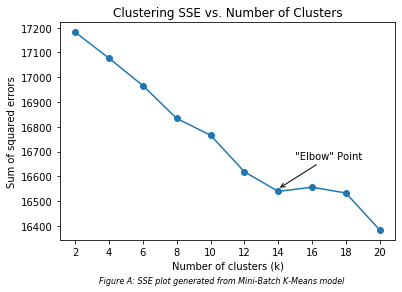

In [9]:
#Let's generate the SSE plot with cluster k starting from 2 and up to 20
msu.generate_SSE_plot(tfidf_docs, 20, 'MiniBatchKMeans', RANDOM_SEED)

# add annotation so reader can see the elbow point
plt.annotate('"Elbow" Point', xy=(14, 16550),  xycoords='data',
            xytext=(19, 16700),
            arrowprops=dict(arrowstyle='->'),
            horizontalalignment='right', verticalalignment='top',
            )

# add title to the figure so it can be easily reference in our blog post
plt.suptitle('Figure A: SSE plot generated from Mini-Batch K-Means model', y=0, style='italic', fontsize=8)

plt.savefig("blog_visualizations/SSE_plot_minik", bbox_inches="tight", dpi=300)
plt.show()


  0%|          | 0/8 [00:00<?, ?it/s]

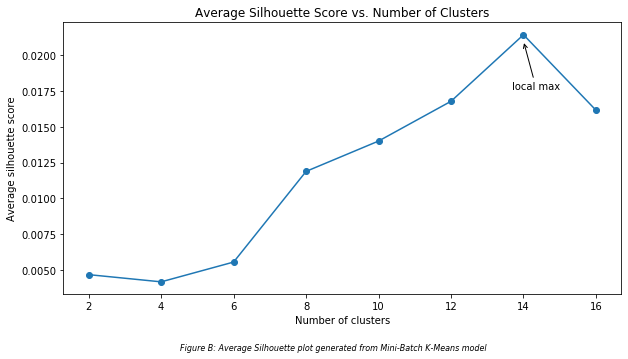

In [10]:
# Let's look at the average silhouette plot
msu.generate_avg_silhouette_plot(tfidf_docs, 16, 'MiniBatchKMeans',RANDOM_SEED)

# add annotation so reader can see the local max
plt.annotate('local max', xy=(14, 0.0210),  xycoords='data',
            xytext=(15, 0.0175),
            arrowprops=dict(arrowstyle='->'),
            horizontalalignment='right', verticalalignment='bottom',
            )

# add title to the figure so it can be easily reference in our blog post
plt.suptitle('Figure B: Average Silhouette plot generated from Mini-Batch K-Means model', y=-.01, style='italic', fontsize=8)

plt.savefig("blog_visualizations/avg_ss_plot_minik", bbox_inches="tight", dpi=300)

plt.show()

In [11]:
# generate the labels based on the "best k cluster" from the elbow method and the average silhouette score
model = MiniBatchKMeans(n_clusters=14, init_size=800, batch_size=1300, random_state=RANDOM_SEED).fit(tfidf_docs)
minik_cluster = model.predict(tfidf_docs)

# add the clustering result as a new column to the job dataframe 
job_df['minik_cluster'] = minik_cluster


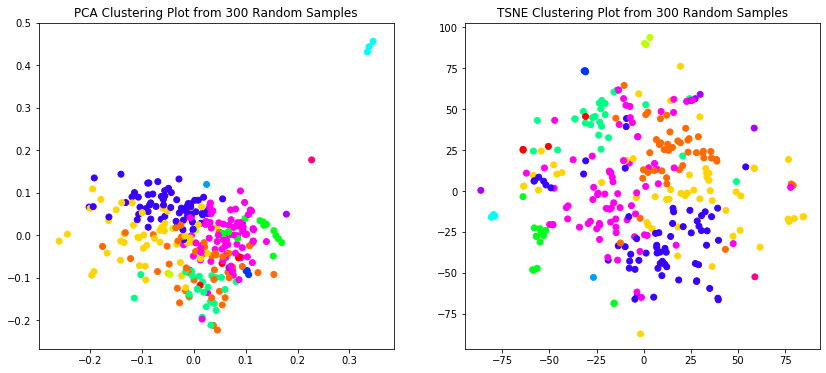

In [12]:
# let's plot the clusters in two dimensions based on the result from the SSE plot
msu.generate_tsne_pca_plot(tfidf_docs, minik_cluster, 14, RANDOM_SEED)

# remember the plots below only show the 300 random samples from our dataset

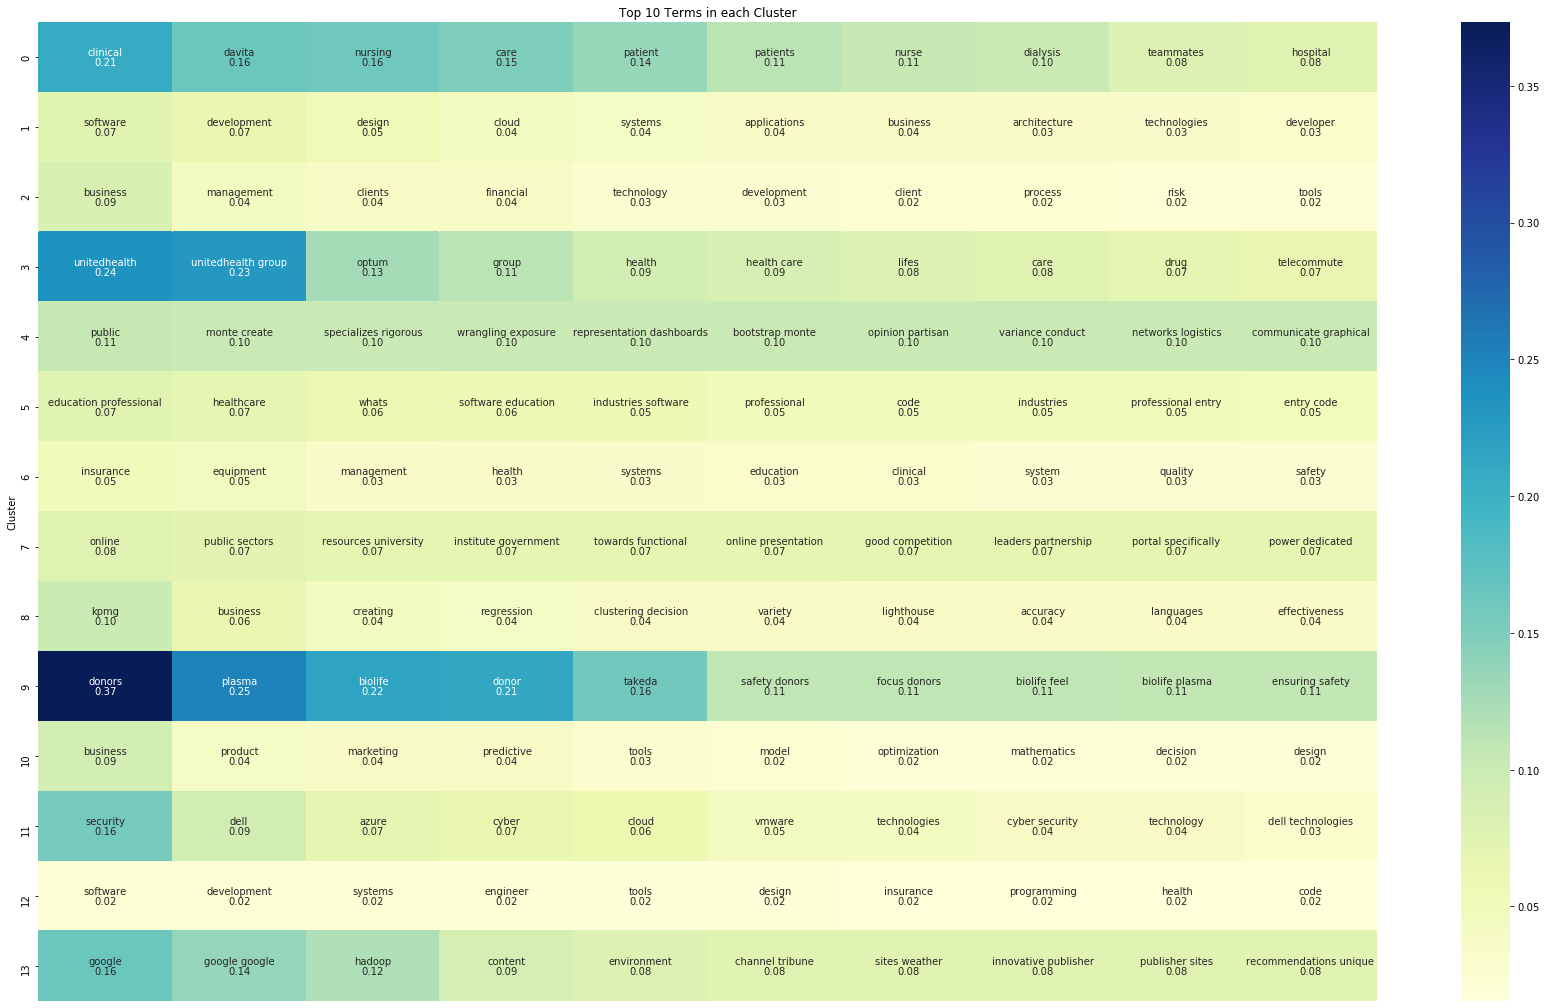

In [13]:
# Let's look at the top 15 words for each cluster
# below is code to just the terms
# msu.get_top_keywords(tfidf_docs, job_df.minik_cluster, tfidf_terms, 10)

# this is to plot the top terms in a heatmap based the term weights
generate_terms_heatmap(tfidf_docs, job_df.minik_cluster, tfidf_terms, 10)

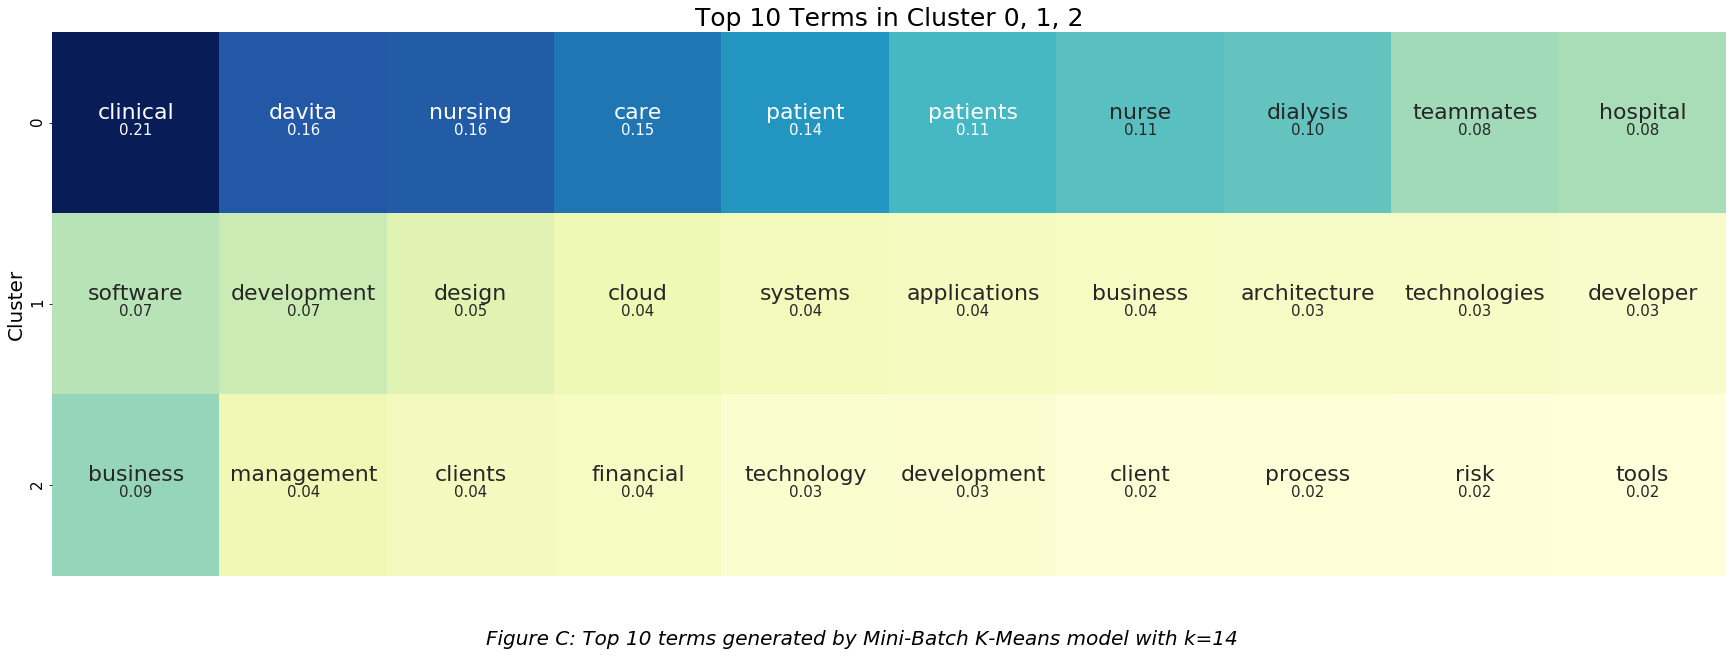

In [14]:
# this is to create the visualization for the blog post
df = pd.DataFrame(tfidf_docs.todense()).groupby(job_df.minik_cluster).mean()
term_weights = []
cluster_terms = []

# only plotting the first three clusters
df_plot = df[df.index<3]
    
for i,r in df_plot.iterrows():
    term_weights.append(sorted(r, reverse=True)[:10])
    cluster_terms.append([tfidf_terms[t] for t in np.argsort(r)[::-1][:10]])
      
fig, ax = plt.subplots(figsize=(30,10))

sns.heatmap(term_weights, ax=ax, cmap='YlGnBu', annot=term_weights, annot_kws={'va':'top', "fontsize":15}, fmt=".2f", xticklabels=False, cbar=False)
sns.heatmap(term_weights, ax=ax, cmap='YlGnBu', annot=cluster_terms , annot_kws={'va':'bottom',"fontsize":22}, fmt="", cbar=False, xticklabels=False)

ax.set_ylabel('Cluster', fontsize=20)
ax.set_title('Top {} Terms in Cluster 0, 1, 2'.format(10), fontsize=25)
plt.yticks(fontsize=15)

# add title to the figure so it can be easily reference in our blog post
plt.suptitle('Figure C: Top 10 terms generated by Mini-Batch K-Means model with k=14', y=0.05, style='italic', fontsize=20)

plt.savefig("blog_visualizations/top_terms_minik", bbox_inches="tight", dpi=300)

plt.show()

In [15]:
# Based on the heatmap above of the top n terms, let's try to label the cluster 
# we are labeling the cluster based on distinct terms in the cluster 
# Note that some of the clusters have the same labels
label_cluster = {0:'healthcare', 1:'tech', 2:'business', 3:'healthcare', 4:'general', 5:'education', 
                 6:'general', 7:'government', 8:'business', 9:'healthcare', 10:'marketing', 
                 11:'tech', 12:'tech', 13:'entertainment'}

job_df['domain_minik'] = job_df['minik_cluster'].map(label_cluster)

job_df.sample(5)


,id,crawl_timestamp,url,job_title,category,company_name,city,state,country,post_date,...,sector,html_job_description,company_description,location,education,skill,cleaned_jd,domain_minik,domain_lr,minik_cluster
12142,111280,2021-07-15,https://www.glassdoor.com/job-listing/senior-m...,"Senior Manager, Machine Learning",None,Harnham,East Boston,MA,UNITED STATES,2021-06-12,...,Business Services,None,None,None,,"cnn, data structures, machine learning, neural...","senior manager, machine learning\ntravel compa...",tech,human resources,12
15992,124899,2021-07-26,https://www.glassdoor.com/job-listing/data-eng...,Data Engineer,None,The Walt Disney Company (Corporate),Davenport,FL,,2021-07-26,...,None,None,None,"Davenport, Florida",,"aws, big data, data analytics, docker, hadoop,...",job summary: the disney decision science and i...,tech,entertainment,1
5394,5701,2019-07-19,https://www.indeed.com/viewjob?jk=a269ce8e27ef...,Biological Data Scientist,Computer-or-internet,Axle Informatics,Rockville,MD,UNITED STATES,2019-07-19,...,,,None,None,bachelor;posdoc,"c++, cuda, deep learning, excel, image process...",overview axle informatics is a scientific rese...,tech,tech,12
265,277,2021-07-08,https://www.glassdoor.com/job-listing/experien...,Experienced Data Engineer,,Liberty Mutual Insurance,Dover,NH,UNITED STATES,2021-06-19,...,Insurance,None,None,None,bachelor;master,"aws, scrum, snowflake, sql, unix","at liberty mutual, our purpose is to help peop...",tech,finance,1
8532,9922,2019-09-09,https://www.theladders.com/job/data-scientist-...,"Data Scientist in Columbus, OH",Data Scientist,Ambercrombie & Fitch,Columbus,OH,UNITED STATES,2019-09-06,...,,"<div class=""job-description job-description-te...",None,None,bachelor,"big data, data structures, decision trees, inf...","company description at abercrombie & fitch, qu...",marketing,tech,10


In [16]:
# # record the result into the database
# connection = pymysql.connect(host=secret['host'],
#                               user=secret['user'],
#                               password=secret['password'],
#                               database=secret['database'],
#                               port=secret['port'],
#                               charset=secret['charset'],
#                               cursorclass=pymysql.cursors.DictCursor)

# cursor = connection.cursor()

# for i in tqdm(range(job_df.shape[0])):
#     id = job_df.iloc[i]['id']
#     domain = job_df.iloc[i]['domain_minik']
#     cursor.execute(f"""UPDATE jd SET domain_minik='{domain}' WHERE id={id};""")

#     if i%1000 == 0:
#       connection.commit()

# connection.commit()
# connection.close()

## 4.B. KMeans
[KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) is an iterative algorithm that tries to partition the dataset into predefined number of clusters and each data point is assigned to only one cluster. As a result, intra-cluster data points should be as similar as possible while keeping the clusters as far as possible. Since KMeans run much slower so we are only training the KMeans to compare the result with the MiniBatchKMeans model.

In [17]:
# let's look the result from KMeans with same number of clusters as the MiniBatchKMeans we used in the section above
clusters_labels = KMeans(n_clusters=14, random_state=RANDOM_SEED).fit_predict(tfidf_docs)

# Let's look at the top 15 words for each cluster
msu.get_top_keywords(tfidf_docs, clusters_labels, tfidf_terms, 15)


Cluster 0
simulation bootstrap,challenging specializes,rigorous public,partisan areas,metrics hands,communicate graphical,networks logistics,variance conduct,opinion partisan,bootstrap monte,representation dashboards,wrangling exposure,specializes rigorous,monte create,public

Cluster 1
beliefs well,religious practices,practices beliefs,strength diverse,management,morgan,investment,small businesses,business,small,jpmorgan chase,jpmorgan,financial,banking,chase

Cluster 2
create,growth,user,tools,marketing,production,code,development,industry,design,technology,software,platform,business,product

Cluster 3
committed principle,union domestic,sensory expression,employees providing,principle employees,based characteristics,tolerate based,employees,cloud,technologies,family,security,dell technologies,vmware,dell

Cluster 4
equity firm,firm growth,growth proven,globally offices,contract market,market date,worked globally,worldwide deliver,date worked,record servicing,google google,cloud,hado